In [1]:
from commonfunctions import *
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier  # MLP is an NN
from sklearn import svm
import numpy as np
import argparse
import imutils  # If you are unable to install this library, ask the TA; we only need this in extract_hsv_histogram.
import cv2
import os
import random


# Depending on library versions on your system, one of the following imports 
from sklearn.model_selection import train_test_split
#from sklearn.cross_validation import train_test_split

import joblib

inpath = '../inputs/'
outpath = '../outputs/segmentation/'

In [2]:
def integral_image(img):
    rows,cols = img.shape
    int_img = np.zeros(img.shape)
    int_img[0][0] = img[0][0]
    for r in range(1,rows):
        int_img[r][0] = int_img[r-1][0] + img[r][0]    
    for c in range(1,cols):
        int_img[0][c] = int_img[0][c-1] + img[0][c]  
    for r in range(1,rows):
        for c in range(1,cols):
            int_img[r][c] = img[r][c]+int_img[r][c-1] +int_img[r-1][c] - int_img[r-1][c-1] 
    return int_img

In [3]:
def segment(img,window,t =10):
    rows,cols = img.shape
    output = np.zeros(img.shape, dtype="uint8")
    int_img = integral_image(img)
    s = int(window/2)
    p_img = np.pad(img,s,"constant")
    p_int = np.pad(int_img,s,'edge')
    for r in range(s+1,rows+s):
        for c in range(s+1,cols+s):
            x1 = c-s
            x2 = c+s
            y1 = r-s
            y2 = r+s
            count = (x2-x1)*(y2-y1)
            sum = p_int[y2,x2] - p_int[y2,x1-1] - p_int[y1-1,x2] + p_int[y1-1,x1-1]
            if(img[r-s][c-s]*count)<=(sum*(100-t)/100):
                output[r-s][c-s]=0
            else:
                output[r-s][c-s]=255
    return output        
                

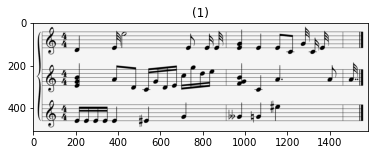

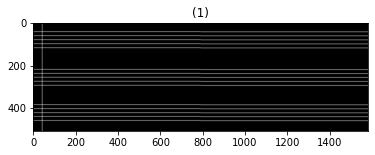

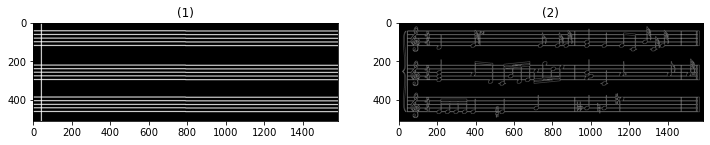

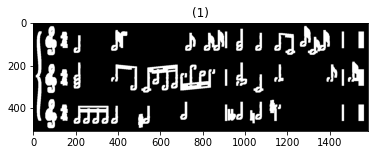

In [4]:
sheet = cv2.imread(inpath+"02.png")
sheet_t = segment(cv2.cvtColor(sheet, cv2.COLOR_BGR2GRAY),11,33)

show_images([sheet])

img = sheet.copy()  
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(gray,50,150)

# get line mask
minLineLength = (img.shape[1] * 2 // 3)
temp_lines = []
hough = cv2.HoughLines(edges,1,np.pi/180,300)
mask = sheet.copy()
mask[:] = 0
for rho,theta in hough[:,0,:]:
    if theta < 10:
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a*rho
        y0 = b*rho
        x1 = int(x0 + img.shape[1]*(-b))
        y1 = int(y0 + img.shape[0]*(a))
        x2 = int(x0 - img.shape[1]*(-b))
        y2 = int(y0 - img.shape[0]*(a))

        cv2.line(mask,(x1,y1),(x2,y2),(255,255,255),1)
        temp_lines.append((rho, theta))
        
temp_lines.sort()

show_images([mask])

mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
kernel = np.ones((3,3),np.uint8)
mask = cv2.dilate(mask,kernel,iterations = 1)
show_images([mask, edges])

# remove lines
result = edges.copy()
result[mask!=0] = 0

# eliminate discontinuities
result = cv2.dilate(result,kernel,iterations = 4)

show_images([result])
# now we have lines

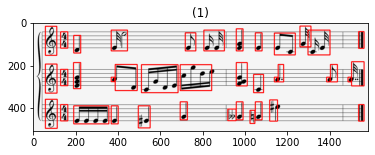

In [37]:
# remove repeated lines
lines = []
j = -1
for i in range(0, len(temp_lines)):
    if j < 0 or abs(lines[j][0] - temp_lines[i][0]) > 5 or abs(lines[j][1] - temp_lines[i][1]) > 2:
        lines.append(temp_lines[i])
        j += 1

# get avg width between 2 lines
avg_width = 0
for i in range(0, 4):
    avg_width += lines[i + 1][0] - lines[i][0] 
avg_width /= 4

# get contours
contours, _ = cv2.findContours(result, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

temp_img = sheet.copy()

id = 0

for contour in contours:
    x,y,w,h = cv2.boundingRect(contour)
    if h < 8 * avg_width and h > avg_width and w > 15:
        c_img = temp_img[y:y+h, x:x+w]
        cv2.imwrite(inpath + 'crops/' + str(id) + '.png' ,c_img)
        id += 1
        cv2.rectangle(temp_img,(x,y),(x+w,y+h),(255,0,0),3)
    
show_images([temp_img])


In [34]:
filename = '../music_notes_NN.joblib.pkl'
loaded_model = joblib.load(filename)
print(loaded_model)

MLPClassifier(hidden_layer_sizes=(500, 100, 50), max_iter=50, random_state=42,
              verbose=1)


In [35]:
target_img_size = (32, 32) 
def extract_hog_features(img):
    """
    TODO
    You won't implement anything in this function. You just need to understand it 
    and understand its parameters (i.e win_size, cell_size, ... etc)
    """
    img = cv2.resize(img, target_img_size)
    win_size = (32, 32)
    cell_size = (4, 4)
    block_size_in_cells = (2, 2)
    
    block_size = (block_size_in_cells[1] * cell_size[1], block_size_in_cells[0] * cell_size[0])
    block_stride = (cell_size[1], cell_size[0])
    nbins = 9  # Number of orientation bins
    hog = cv2.HOGDescriptor(win_size, block_size, block_stride, cell_size, nbins)
    h = hog.compute(img)
    h = h.flatten()
    return h.flatten()

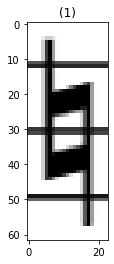

natural


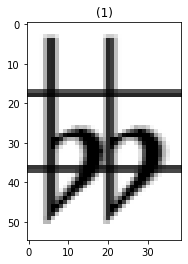

flat


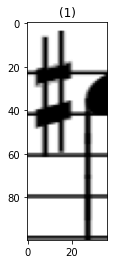

natural


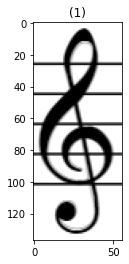

clef


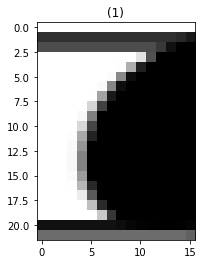

a_8


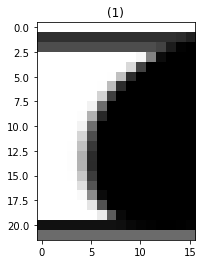

a_8


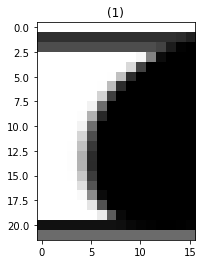

a_8


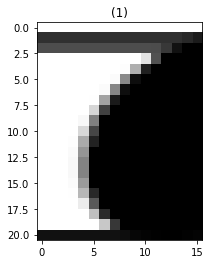

a_4


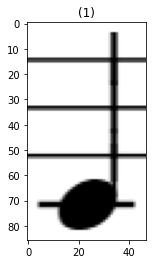

a_8


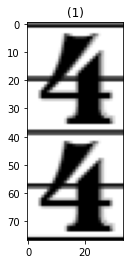

t_4_4


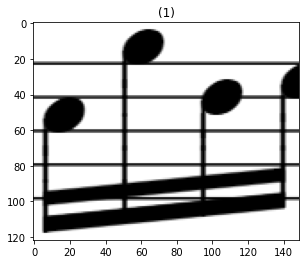

b_32


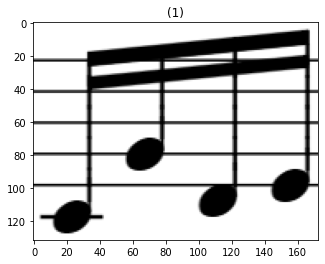

b_16


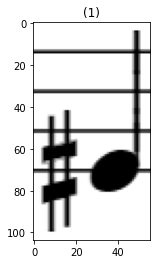

a_8


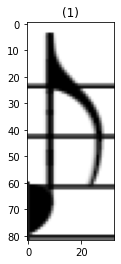

a_16


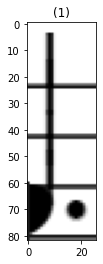

flat


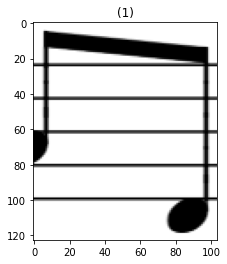

t_3_4


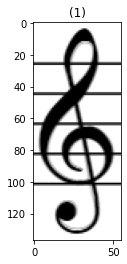

clef


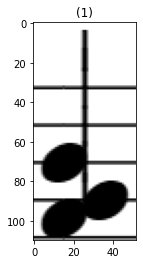

t_3_8


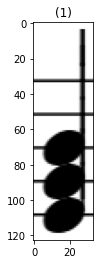

b_8


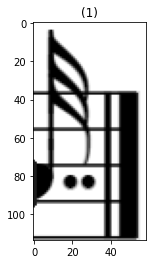

b_32


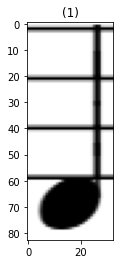

a_2


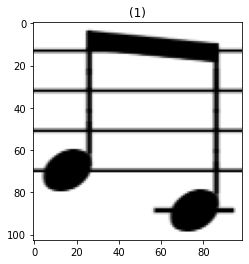

t_3_4


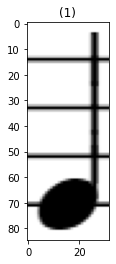

a_8


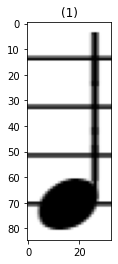

a_8


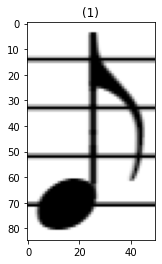

a_8


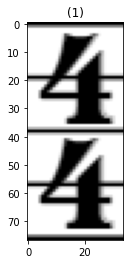

t_4_4


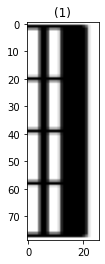

barline


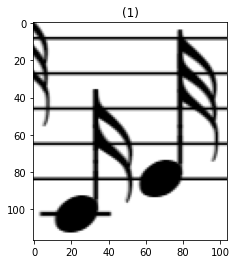

a_32


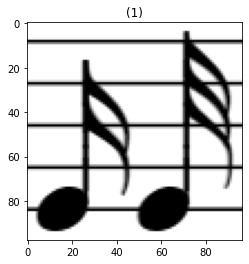

a_16


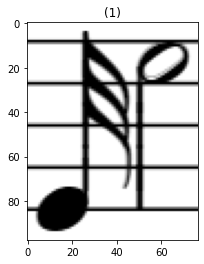

a_16


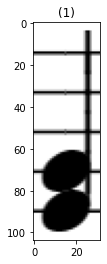

t_3_8


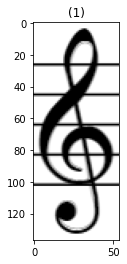

clef


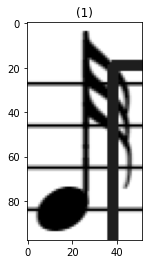

a_16


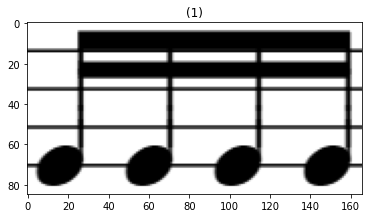

t_6_8


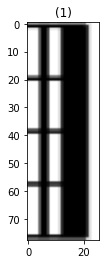

barline


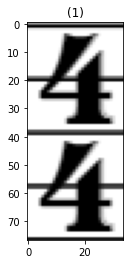

t_4_4


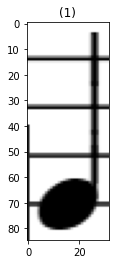

a_8


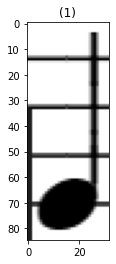

a_8


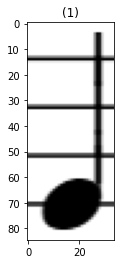

a_8


In [38]:
crops_path = inpath + 'crops/'
crop_filenames = os.listdir(crops_path)
classes = loaded_model.classes_

for i, fn in enumerate(crop_filenames):
    if fn.split('.')[-1] != 'png':
        continue
    path = os.path.join(crops_path, fn)
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    show_images([img])
    features = extract_hog_features(img)
    print(classes[np.argmax( loaded_model.predict_proba([features]))])
                       